# Classifying Fashion-MNIST

Now it's your turn to build and train a neural network. You'll be using the [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist), a drop-in replacement for the MNIST dataset. MNIST is actually quite trivial with neural networks where you can easily achieve better than 97% accuracy. Fashion-MNIST is a set of 28x28 greyscale images of clothes. It's more complex than MNIST, so it's a better representation of the actual performance of your network, and a better representation of datasets you'll use in the real world.

<img src='assets/fashion-mnist-sprite.png' width=500px>

In this notebook, you'll build your own neural network. For the most part, you could just copy and paste the code from Part 3, but you wouldn't be learning. It's important for you to write the code yourself and get it to work. Feel free to consult the previous notebooks though as you work through this.

First off, let's load the dataset through torchvision.

In [1]:
import helper
import torch
from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
# Download and load the training data
trainset = datasets.FashionMNIST("~/.pytorch/F_MNIST_data/", download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST("~/.pytorch/F_MNIST_data/", download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

100.0%


Extracting /home/lucas/.pytorch/F_MNIST_data/FashionMNIST/raw/train-images-idx3-ubyte.gz to /home/lucas/.pytorch/F_MNIST_data/FashionMNIST/raw


100.0%


Extracting /home/lucas/.pytorch/F_MNIST_data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /home/lucas/.pytorch/F_MNIST_data/FashionMNIST/raw




10.4%

100.0%
100.0%

Extracting /home/lucas/.pytorch/F_MNIST_data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /home/lucas/.pytorch/F_MNIST_data/FashionMNIST/raw

Extracting /home/lucas/.pytorch/F_MNIST_data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /home/lucas/.pytorch/F_MNIST_data/FashionMNIST/raw



Here we can see one of the images.

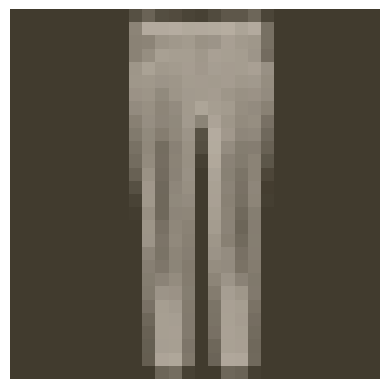

In [2]:
image, label = next(iter(trainloader))
helper.imshow(image[0, :]);

## Building the network

Here you should define your network. As with MNIST, each image is 28x28 which is a total of 784 pixels, and there are 10 classes. You should include at least one hidden layer. We suggest you use ReLU activations for the layers and to return the logits or log-softmax from the forward pass. It's up to you how many layers you add and the size of those layers.

In [42]:
# TODO: Define your network architecture here
import torch.nn as nn
from torch.nn.functional import log_softmax, relu

class Network(nn.Module):
    def __init__(self, input_size, output_size, layer_sizes):
        super(Network, self).__init__()

        self.linears = nn.ModuleList([nn.Linear(input_size, layer_sizes[0])])
        self.linears.extend([nn.Linear(layer_sizes[i-1], layer_sizes[i]) for i in range(1,len(layer_sizes))])
        self.linears.append(nn.Linear(layer_sizes[-1], output_size))
    
    def forward(self, x):
        for fc in self.linears[0:-1]:
            x = fc(x)
            x = relu(x)
        x = self.linears[-1](x)
        return log_softmax(x ,dim = 1)

input_size = 784
output_size = 10
layer_sizes = [256, 128, 64]

net = Network(input_size=input_size, output_size=output_size, layer_sizes=layer_sizes)
test_input = torch.rand((1,input_size))
net.forward(test_input)


tensor([[-2.1818, -2.2890, -2.3580, -2.3429, -2.1031, -2.4699, -2.3524, -2.2990,
         -2.2724, -2.4091]], grad_fn=<LogSoftmaxBackward0>)

# Train the network

Now you should create your network and train it. First you'll want to define [the criterion](http://pytorch.org/docs/master/nn.html#loss-functions) ( something like `nn.CrossEntropyLoss`) and [the optimizer](http://pytorch.org/docs/master/optim.html) (typically `optim.SGD` or `optim.Adam`).

Then write the training code. Remember the training pass is a fairly straightforward process:

* Make a forward pass through the network to get the logits 
* Use the logits to calculate the loss
* Perform a backward pass through the network with `loss.backward()` to calculate the gradients
* Take a step with the optimizer to update the weights

By adjusting the hyperparameters (hidden units, learning rate, etc), you should be able to get the training loss below 0.4.

In [46]:
# TODO: Create the network, define the criterion and optimizer
from torch.nn import CrossEntropyLoss
from torch.optim import Adam

input_size = 784
output_size = 10
layer_sizes = [128, 64]

net = Network(input_size=input_size, output_size=output_size, layer_sizes=layer_sizes)
criterion = CrossEntropyLoss()
optimizer = Adam(net.parameters(), lr = 1e-3)

In [47]:
epochs = 5
for e in range(epochs):
    epoch_loss = 0
    for images, labels in trainloader:
        images = images.view(images.shape[0], -1)

        logits = net.forward(images)
        loss = criterion(logits, labels)
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()

        epoch_loss += loss.item()
    if e % 5 == 0:
        ps = torch.exp(logits[-1, :])
        print(torch.sum(ps))
        predicted_class = torch.argmax(ps)
        print(f"Model classifies last image as Class {predicted_class} with probability {ps[predicted_class]:.3f}")
        print(f"Loss in epoch {e+1} is {epoch_loss:.4f}" )


tensor(1.0000, grad_fn=<SumBackward0>)
Model classifies last image as Class 8 with probability 1.000
Loss in epoch 1 is 479.3951


tensor([[1.0075e-05, 1.9005e-07, 2.6690e-06, 7.9400e-06, 1.8439e-06, 6.9740e-04,
         2.0682e-06, 2.4085e-01, 5.3907e-06, 7.5842e-01]],
       grad_fn=<ExpBackward0>)


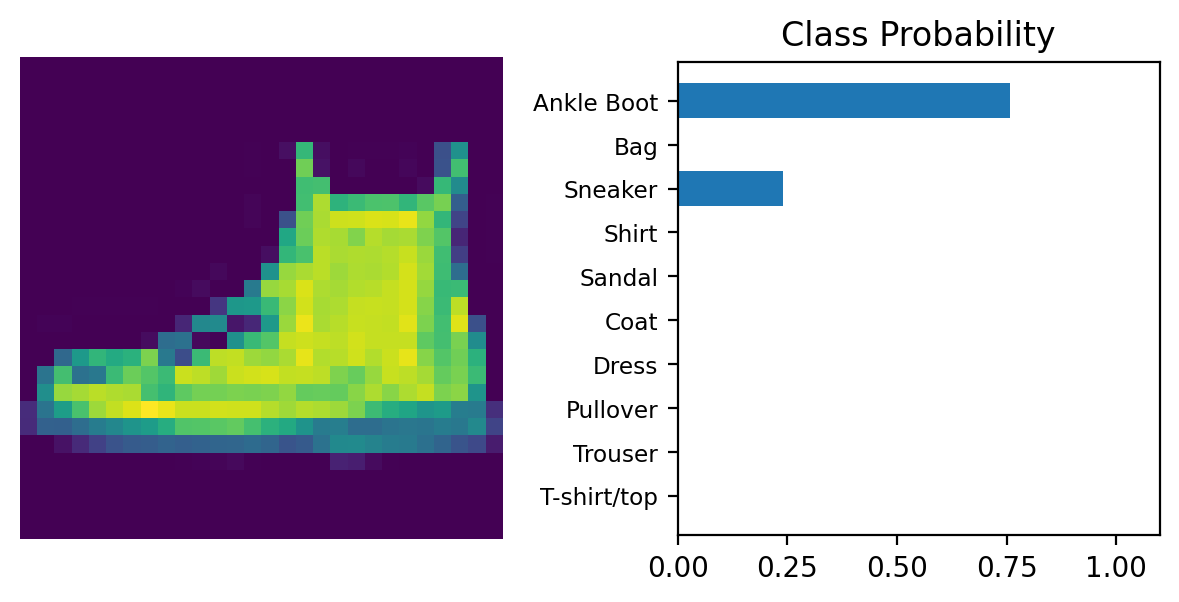

In [55]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import helper

# Test out your network!

dataiter = iter(testloader)
images, labels = next(dataiter)
img = images[0]
# Convert 2D image to 1D vector
img = img.resize_(1, 784)

# TODO: Calculate the class probabilities (softmax) for img
ps = torch.exp(net.forward(img))
print(ps)
# Plot the image and probabilities
helper.view_classify(img.resize_(1, 28, 28), ps, version="Fashion")